# Models for Sequence Data

The goal of this exercise is to explore the structure, speed, and data flow in each of the 4 main kinds of models that are often used for sequence data: feedforward, recurrent (LSTM/GRU), convolutional, and self-attention (Transformer).

This level of knowledge of how each model works should equip you to make wise decisions about when to use each one, without having to get too much into the details of how each one works.

## Setup

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def highlight_values(x):
    """Show a 2D tensor with background highlighted"""
    x = x.squeeze() # collapse singleton dimensions, like batch.
    assert len(x.shape) == 2, "Can only handle 2D data"
    display(pd.DataFrame(x.numpy()).style.background_gradient(axis=None))
    plt.plot(x.norm(dim=1)); plt.title("Norm on axis 1")

def num_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

def time_trial(model, embeddings, concat_on_axis=1):
    '''Time how long a forward pass of the model takes on embeddings, varying the sequence length.'''
    for i in range(5):
        num_reps = 2 ** i
        x = torch.cat([embeddings] * num_reps, axis=concat_on_axis)
        print(f'{num_reps} repetitions of the original sequence, shape = {tuple(x.shape)}')
        %timeit -r 3 model(x)

## Getting started

Let's start with an input sequence.

In [159]:
sentence = "The quick brown fox jumped over the lazy dogs."

Let's turn it into numbers by using the Unicode code point for each character. We'll make a "batch" of one sequence.

In [160]:
sentence_tensor = torch.tensor([[ord(x) for x in sentence]])
sentence_tensor

tensor([[ 84, 104, 101,  32, 113, 117, 105,  99, 107,  32,  98, 114, 111, 119,
         110,  32, 102, 111, 120,  32, 106, 117, 109, 112, 101, 100,  32, 111,
         118, 101, 114,  32, 116, 104, 101,  32, 108,  97, 122, 121,  32, 100,
         111, 103, 115,  46]])

In [161]:
def decode(x):
    return ''.join(chr(x) for x in x.numpy())
decode(sentence_tensor[0])

'The quick brown fox jumped over the lazy dogs.'

We'll make this an autoregressive language model, so our goal will be to predict the next character. So we'll need to shift the targets left, so each character should output the next one.

In [162]:
targets = sentence_tensor[:, 1:]
input_ids = sentence_tensor[:, :-1]
assert input_ids.shape == targets.shape

Now let's make those numbers into vectors using an embedding. Note that we're just going to use the random initialization right now; we're not yet training this model.

In [163]:
n_vocab = 256
emb_dim = 5
embedder = nn.Embedding(n_vocab, emb_dim)
embedder.weight.shape

torch.Size([256, 5])

In [164]:
num_parameters(embedder)

1280

Now we compute the embeddings for our string. **Make sure you can explain the shape of this result.**

In [165]:
embeddings = embedder(input_ids)
embeddings.shape

torch.Size([1, 45, 5])

Now we'll define the linear layer that goes from embeddings back to words. This is usually called the "language modeling head". We'll *tie the weights* of the LM head with the embedding layer, saving some parameters.

In [166]:
lm_head = nn.Linear(emb_dim, n_vocab)
assert lm_head.weight.shape == embedder.weight.shape
lm_head.weight = embedder.weight

Here's what the output of the model will look like. We haven't trained anything yet, though, so the specific numbers will be garbage, but the shape is right and that's most of the battle.

In [167]:
x = embeddings # pretend that this is the model...
logits = lm_head(x)
logits.shape

torch.Size([1, 45, 256])

Then we'll compute the cross-entropy loss as usual.

Note: we need to `transpose` the `logits` so that the time steps are on the last dimension, so the last dimensions line up with `targets`. I suspect PyTorch uses this convention because it could extend to 2D `targets` (e.g., images), but I admit I'm not entirely sure why.

In [168]:
loss = F.cross_entropy(logits.transpose(1, 2), targets, reduction='none')
loss.shape

torch.Size([1, 45])

## Feed-Forward Network

Here's the simplest model we can make: a multi-layer perceptron. Fill in the blanks here so our model has *one hidden layer* with a *relu activation* (`nn.ReLU`).

- The output should have the same dimensionality as the embeddings
- Set `n_hidden` so that there are about 180 parameters.

### Create the model

In [169]:
# n_hidden = ...
n_hidden = 16
mlp = nn.Sequential(
    # nn.Linear(in_features=..., out_features=n_hidden),
    nn.Linear(in_features=emb_dim, out_features=n_hidden),
    # nn...,
    nn.ReLU(),
    # nn...
    nn.Linear(in_features=n_hidden, out_features=emb_dim)
)

num_parameters(mlp)

181

### Check its output shape

In [170]:
output = mlp(embeddings)
output.shape

torch.Size([1, 45, 5])

### Check its speed

In [171]:
time_trial(mlp, embeddings)

1 repetitions of the original sequence, shape = (1, 45, 5)
48.4 µs ± 935 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)
2 repetitions of the original sequence, shape = (1, 90, 5)
47.5 µs ± 618 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)
4 repetitions of the original sequence, shape = (1, 180, 5)
52.4 µs ± 1.73 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)
8 repetitions of the original sequence, shape = (1, 360, 5)
60 µs ± 1.55 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)
16 repetitions of the original sequence, shape = (1, 720, 5)
71.1 µs ± 3.16 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)


### Check how gradients flow

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000


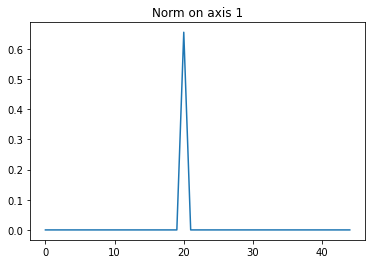

In [173]:
# Recreate the embeddings
embeddings = embedder(input_ids)
embeddings.retain_grad() # Tell Torch we want to know what the gradients are here.
# Pass the embeddings through the model and language modeling head.
output = mlp(embeddings)
logits = lm_head(output)
# Compute the loss
loss = F.cross_entropy(logits.transpose(1, 2), targets, reduction='none')
# Let the model learn from one single character (the one at index 20)
loss[0, 20].backward()
# Show the results
highlight_values(embeddings.grad)

## GRU

In [174]:
gru = nn.GRU(emb_dim, emb_dim, batch_first=True)
num_parameters(gru)

180

In [175]:
output, hidden = gru(embeddings)
output.shape, hidden.shape

(torch.Size([1, 45, 5]), torch.Size([1, 1, 5]))

Note that `hidden` is just another name for the output at the last state (since GRU is simple).

In [176]:
(output[:, -1, :] == hidden).all()

tensor(True)

### Your turn

1. Repeat the time trial, but for `gru` this time.


In [177]:
time_trial(gru, embeddings)

1 repetitions of the original sequence, shape = (1, 45, 5)
1.66 ms ± 37.2 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
2 repetitions of the original sequence, shape = (1, 90, 5)
3.14 ms ± 40.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
4 repetitions of the original sequence, shape = (1, 180, 5)
6.47 ms ± 13.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
8 repetitions of the original sequence, shape = (1, 360, 5)
14.6 ms ± 146 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
16 repetitions of the original sequence, shape = (1, 720, 5)
32.9 ms ± 187 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


2. Repeat the gradient-flow experiment by copy-pasting the code above and changing the model. Remember that `gru` returns `output, hidden`, unlike the other models.

,0,1,2,3,4
0,0.000010,0.000002,0.000001,-0.000013,-0.000004
1,0.000001,0.000029,0.000003,-0.000031,-0.000022
2,0.000001,0.000052,0.000015,-0.000050,-0.000041
3,0.000005,0.000043,0.000040,-0.000056,-0.000019
4,0.000005,0.000030,-0.000026,-0.000018,-0.000026
5,0.000056,0.000082,0.000030,-0.000082,-0.000051
6,-0.000013,0.000117,0.000058,-0.000048,-0.000095
7,0.000007,0.000043,-0.000077,0.000096,-0.000166
8,0.000067,0.000030,0.000096,0.000034,-0.000239
9,-0.000464,-0.000437,0.000261,0.000889,-0.000302


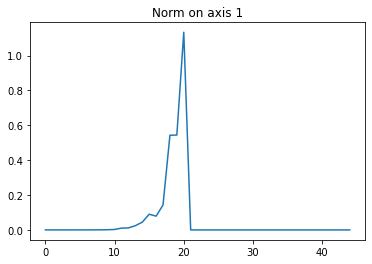

In [178]:
# Recreate the embeddings
embeddings = embedder(input_ids)
embeddings.retain_grad() # Tell Torch we want to know what the gradients are here.
# Pass the embeddings through the model and language modeling head.
# your code here
output, hidden = gru(embeddings)
logits = lm_head(output)
# Compute the loss
loss = F.cross_entropy(logits.transpose(1, 2), targets, reduction='none')
# Let the model learn from one single character (the one at index 20)
loss[0, 20].backward()
# Show the results
highlight_values(embeddings.grad)

## Convolution

Now let's make a convolutional network. We'll pick a "kernel size" (how wide a window for each sample to look) so that the total number of parameters matches our previous models. We also need to pad the result so that the output length is the same as the input length; the outputs near the edges won't be valid outputs, though.

In [179]:
conv = nn.Conv1d(emb_dim, emb_dim, kernel_size=7, padding=3)
num_parameters(conv)

180

Unfortunately Conv expects its inputs to be (batch size, *channel*, sequence length), where they think of embedding dimensions as being "channels" -- confusing. Fortunately, this is easily solved by a `transpose` before and after the conv. (not to be confused with "transposed convolution", which is something different.)

In [180]:
embeddings_for_conv = embeddings.transpose(1, 2)
embeddings_for_conv.shape

torch.Size([1, 5, 45])

In [181]:
output = conv(embeddings.transpose(1, 2)).transpose(1, 2)
output.shape

torch.Size([1, 45, 5])

The fact that we had to transpose the embeddings means that we need to tweak `time_trial` to tell it which dimension is the sequence dimension.

In [106]:
time_trial(conv, embeddings_for_conv, concat_on_axis=2)

1 repetitions of the original sequence, shape = (1, 5, 45)
29.8 µs ± 664 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)
2 repetitions of the original sequence, shape = (1, 5, 90)
33.5 µs ± 3.43 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)
4 repetitions of the original sequence, shape = (1, 5, 180)
29.9 µs ± 164 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)
8 repetitions of the original sequence, shape = (1, 5, 360)
32.7 µs ± 284 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)
16 repetitions of the original sequence, shape = (1, 5, 720)
37.6 µs ± 391 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)


**Your turn**: Repeat the gradient-flow experiment. Make sure you compute `output` as we did above so that the shape is correct.

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000


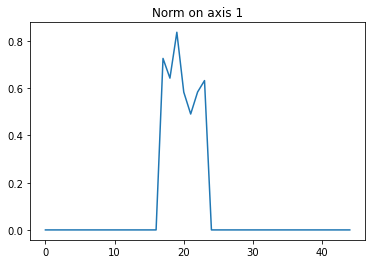

In [182]:
# your code here
# Recreate the embeddings
embeddings = embedder(input_ids)
embeddings.retain_grad() # Tell Torch we want to know what the gradients are here.
# Pass the embeddings through the model and language modeling head.
output = conv(embeddings.transpose(1, 2)).transpose(1, 2)
logits = lm_head(output)
# Compute the loss
loss = F.cross_entropy(logits.transpose(1, 2), targets, reduction='none')
# Let the model learn from one single character (the one at index 20)
loss[0, 20].backward()
# Show the results
highlight_values(embeddings.grad)

## Transformer

Alright, you know the drill by now.

In [134]:
xformer = nn.TransformerEncoderLayer(
    d_model=emb_dim,
    nhead=1,
    dim_feedforward=emb_dim,
    batch_first=True)
num_parameters(xformer)

200

In [132]:
output = xformer(embeddings)
output.shape

torch.Size([1, 45, 5])

In [133]:
time_trial(xformer, embeddings)

1 repetitions of the original sequence, shape = (1, 45, 5)
594 µs ± 11.9 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
2 repetitions of the original sequence, shape = (1, 90, 5)
685 µs ± 14.9 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
4 repetitions of the original sequence, shape = (1, 180, 5)
830 µs ± 6.17 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
8 repetitions of the original sequence, shape = (1, 360, 5)
1.05 ms ± 8.87 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
16 repetitions of the original sequence, shape = (1, 720, 5)
1.6 ms ± 29.1 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


,0,1,2,3,4
0,-0.023746,0.012741,-0.010468,-0.016179,0.003972
1,-0.043304,0.026389,-0.016095,-0.058594,-0.052509
2,-0.027488,0.017300,-0.009696,-0.042254,-0.043724
3,-0.000467,-0.000026,-0.000468,0.002232,0.005316
4,-0.038142,0.022446,-0.014933,-0.044261,-0.031157
5,-0.038549,0.023001,-0.014793,-0.047636,-0.037451
6,-0.029686,0.017581,-0.011518,-0.035467,-0.026340
7,-0.001075,-0.000060,-0.001079,0.005140,0.012242
8,-0.029790,0.017115,-0.012058,-0.030733,-0.016454
9,-0.024645,0.013561,-0.010543,-0.019913,-0.002289


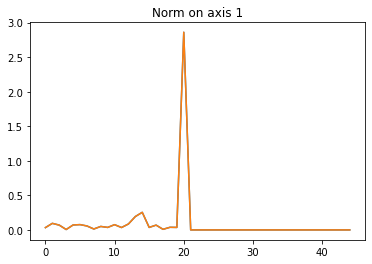

In [183]:
mask = None
# Then, try this:
# mask = nn.Transformer.generate_square_subsequent_mask(embeddings.shape[-2])

# Recreate the embeddings
embeddings = embedder(input_ids)
embeddings.retain_grad() # Tell Torch we want to know what the gradients are here.
# Pass the embeddings through the model and language modeling head.
output = xformer(embeddings, mask)
logits = lm_head(output)
# Compute the loss
loss = F.cross_entropy(logits.transpose(1, 2), targets, reduction='none')
# Let the model learn from one single character (the one at index 20)
loss[0, 20].backward()
# Show the results
highlight_values(embeddings.grad)
# Show how big the gradient is (the "norm") 
plt.plot(embeddings.grad.norm(dim=2).squeeze())

# Analysis

Q1: Explain the shape of each model's output.

Q2: Compare the speeds of the models. Which are fastest on short sequences? How does each model's speed change as the sequence length increases?

Q3: Explain your observations about speed in the previous question by referring to how each model is structured. (i.e., *why* does Conv's speed not change much as the sequence length gets longer?) Think about what operations can happen in parallel.

Q4: We back-propagated the loss of a single character (the one at index 20) back to the embeddings. If an input token was used as part of making that prediction, its embedding vector will have a non-zero gradient. **Describe which tokens were used when making the prediction for the character at index 20**, for each model.

Q5: Explain your observations from the previous question by referring to how each model is structured.

Q6: How many parameters does the `embedder` have? How many parameters does the `lm_head` have? How does this compare with the number of parameters in the model itself? In light of this, why might it make sense to tie the weights of those two modules as we did?